<div align="center">

# DSC4828 Assignment 7 Part 2
### Ozzey Padayachee  
#### 64971759  

</div>

Exploratory data analysis on domestic electrical consumption over two decades in South Africa. The study’s goal is about electricity demand forecasting and infrastructure planning.

- DELSKV: socio-demographic survey data of households for which metered electrical
consumption data is also available.

- DELMH: Hourly data of domestic electrical load metering, 1994 – 2014.

The aim of this part of the assignment is to do EDA on the data.

In [ ]:
import glob
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file_path = r"C:\Users\ozzey\DataspellProjects\dsc4828_capstone\ElectricityData"

# Glob all CSVs
files = glob.glob(file_path + "/*.csv")

# Read each CSV into a list
dfs = [pd.read_csv(f, encoding="utf-8") for f in files]

# Concatenate all at once
delmh = pd.concat(dfs, ignore_index=True)

delskv = pd.read_csv("C:\\Users\\ozzey\\DataspellProjects\\dsc4828_capstone\\ElectricityData\\DEL\\delskv-1994-2014.csv")

From the "The Domestic Electrical Load (DEL) Study Datasets for South Africa" by Wiebke Toussaint research paper, it is explained how the data was captures, how it was processes, stored, how validation was performed, any adjustments to time or scale of measurements. 

In [62]:
delmh['Valid'].value_counts(normalize=True) * 100

Valid
1.0    83.58134
0.0    16.41866
Name: proportion, dtype: float64

We note the imbalance in this and we could consider dropping these rows (and the linked rows in the delskv-1994-2014 dataset)

In [ ]:
# Drop invalid rows
delmh = delmh[delmh['Valid'] == 1].copy()

In [ ]:
# Convert both data frames to dask dataframes to run faster
delmh_dd = dd.from_pandas(delmh, npartitions=10)
delskv_dd = dd.from_pandas(delskv, npartitions=1) 

In [69]:
# Aggregate unitsread per profile ID which is the link to delskv
units_per_profile = delmh_dd.groupby('ProfileID')['Unitsread'].mean().reset_index()

# Ensure consistent types for merge 
units_per_profile['ProfileID'] = units_per_profile['ProfileID'].astype(str)
delskv_dd['ProfileID'] = delskv_dd['ProfileID'].astype(str)

# Merge 
merged_dd = units_per_profile.merge(delskv_dd, on='ProfileID', how='left')

# Drop rows with missing Year or Unitsread 
merged_dd = merged_dd[~merged_dd['Year'].isna()]
merged_dd = merged_dd[~merged_dd['Unitsread'].isna()]

# Convert Year to integer 
merged_dd['Year'] = merged_dd['Year'].astype(int)
merged = merged_dd.compute()

### Which municipalities have higher electricity usage?

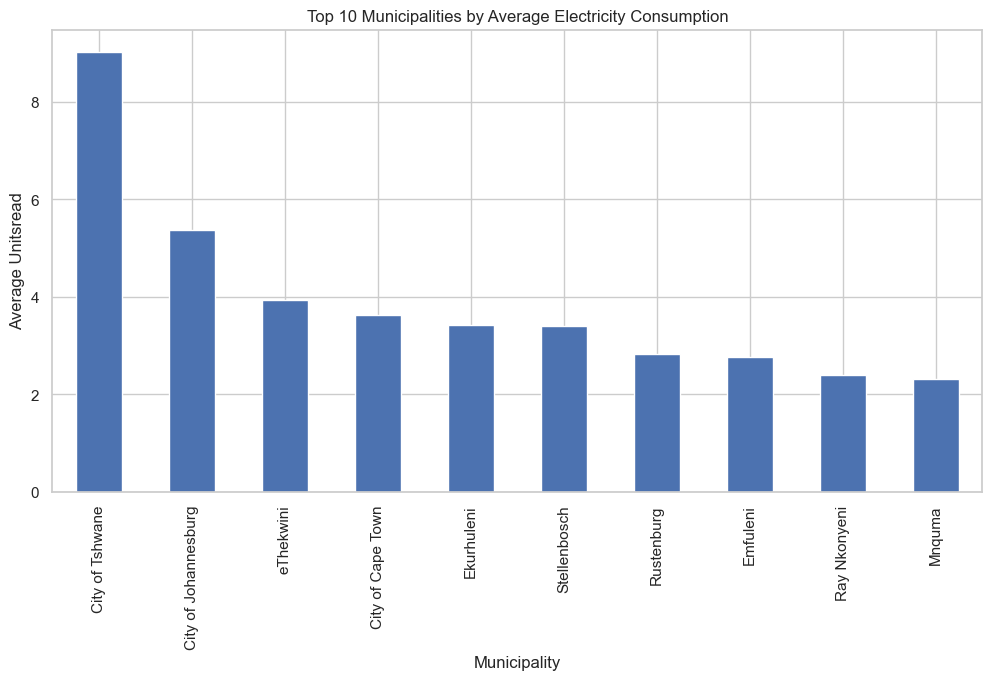

In [72]:
# Top 10 municipalities by average usage
# Group by ('Municipality')['Unitsread'] and take the mean
top_munis = merged_dd.groupby('Municipality')['Unitsread'].mean().nlargest(10).compute()
top_munis.plot(kind='bar', figsize=(12,6))
plt.title("Top 10 Municipalities by Average Electricity Consumption")
plt.ylabel("Average Unitsread")
plt.show()

### Which suburbs have higher electricity usage?

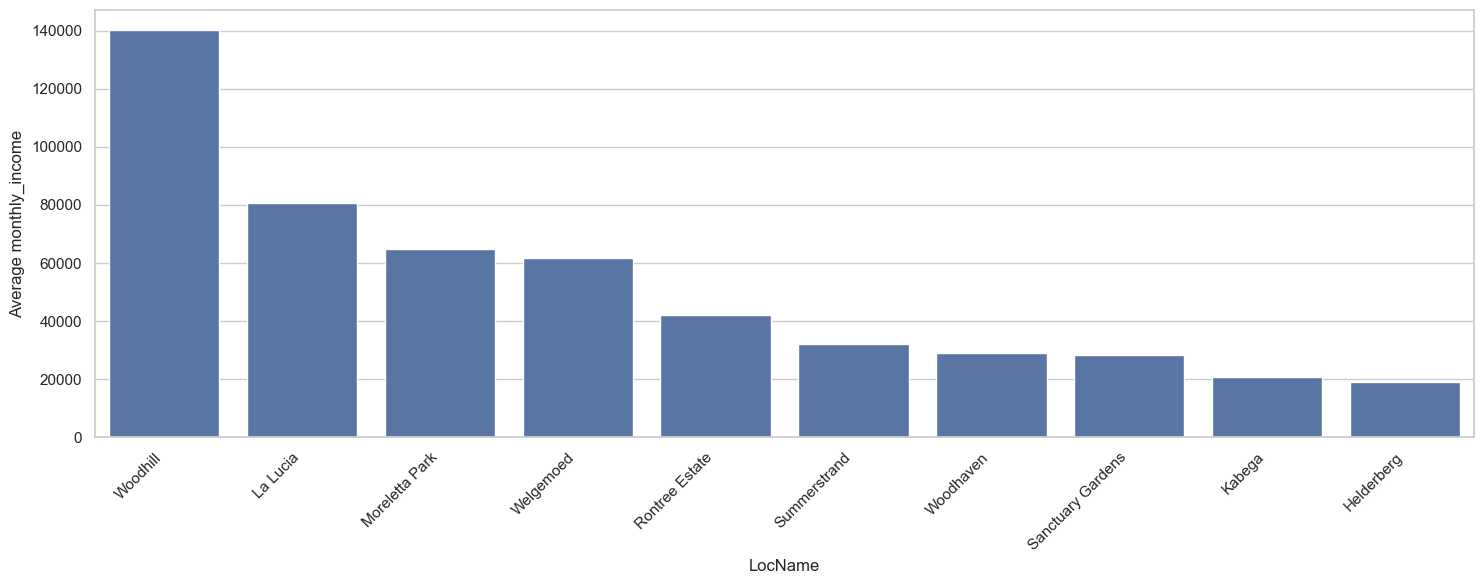

In [73]:
# Group by (['LocName'])['monthly_income'] and take the mean
income = merged.groupby(['LocName'])['monthly_income'].mean().reset_index()
income = income.rename(columns={'monthly_income': 'Average monthly_income'})
 
plt.figure(figsize=(15, 6)) 
sns.barplot(data=income.sort_values('Average monthly_income', ascending=False).head(10), x='LocName', y='Average monthly_income')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Is there a pattern in Unitsread? 
Maybe this could tell us about how people purchase/ use electricity.

The Domestic Electrical Load Study Datasets measure electricity consumption primarily using Amperes (A), which measures the electrical current flowing into a household. For the purpose of analysis, this current is  converted into kilowatt hours (kWh), which is the standard unit for electrical energy consumption over time. We can see the data mostly recording 0-10 units which for households means they are either buying power as they go or not using much. 

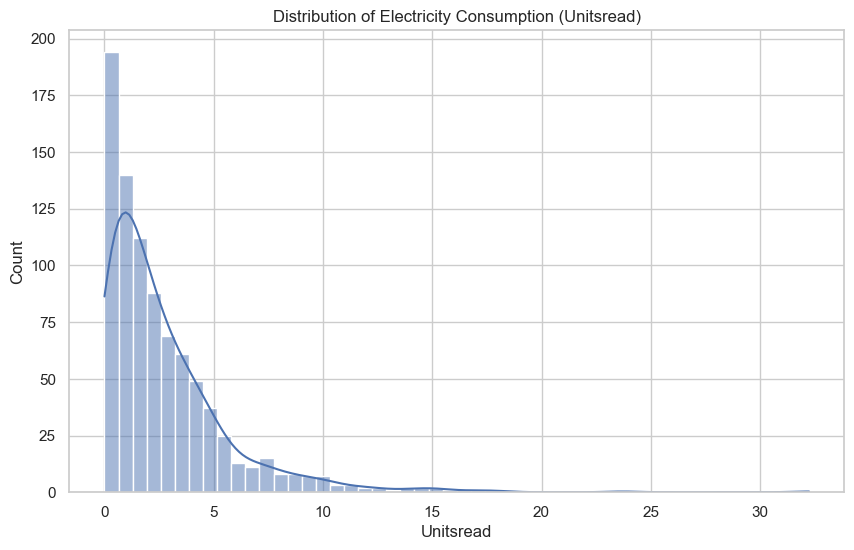

In [88]:
sample = merged_dd[['Unitsread']].sample(frac=0.1, random_state=42).compute()

plt.figure(figsize=(10,6))
sns.histplot(sample['Unitsread'], bins=50, kde=True)
plt.title("Distribution of Electricity Consumption (Unitsread)")
plt.xlabel("Unitsread")
plt.ylabel("Count")
plt.show()

### What is the trend in Unitsread over the period? 
Are there any places in the chart that could correspond to political/ economic events? 

Yes. After the changing of the South African government in 1994, we see a trend up in the usage. This lasts till 2000, and then slowly rises and falls again. Note that during the 2007-2008 period the world was in a financial crisis but we see a flat trend in useage in this period which could mean that that did not effect peoples demand for power. Note that there is missing data hence the drop from 1994-1996. 

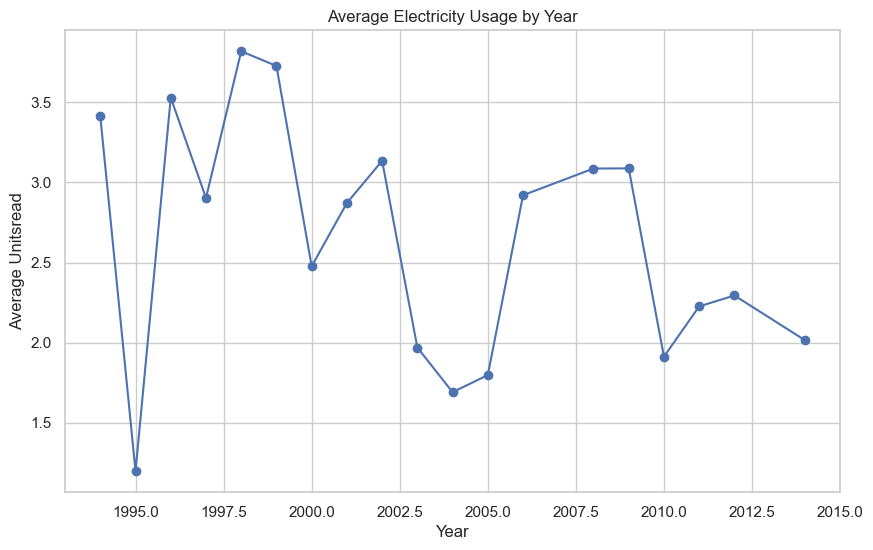

In [75]:
yearly_avg = merged_dd.groupby('Year')['Unitsread'].mean().compute()

plt.figure(figsize=(10,6))
yearly_avg.plot(marker='o')
plt.title("Average Electricity Usage by Year")
plt.xlabel("Year")
plt.ylabel("Average Unitsread")
plt.show()

### Within the dataset, if we performed modeling, which numeric features have the highest correlation? 

There are some interesting things to note here, unsurprisingly, monthly_income is highly correlated with unemployment. total_adults and total_children are strongly correlated with household_size, could indicate growing population and investment in housing. 

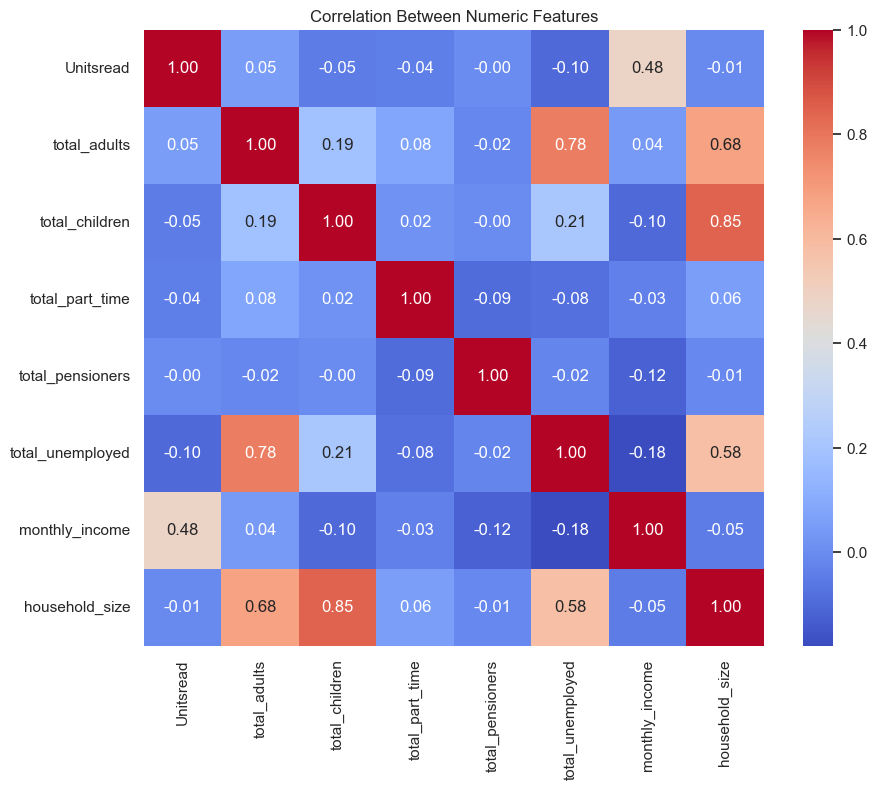

In [81]:
# Compute column household_size as the sum of adults and children
merged_dd['household_size'] = merged_dd['total_adults'] + merged_dd['total_children']

numeric_cols = ['Unitsread', 'total_adults', 'total_children', 'total_part_time', 'total_pensioners', 'total_unemployed', 'monthly_income', 'household_size']
sample = merged_dd[numeric_cols].sample(frac=0.1, random_state=42).compute()

plt.figure(figsize=(10,8))
sns.heatmap(sample.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

### Trend of Average Units Read Over Years by Survey

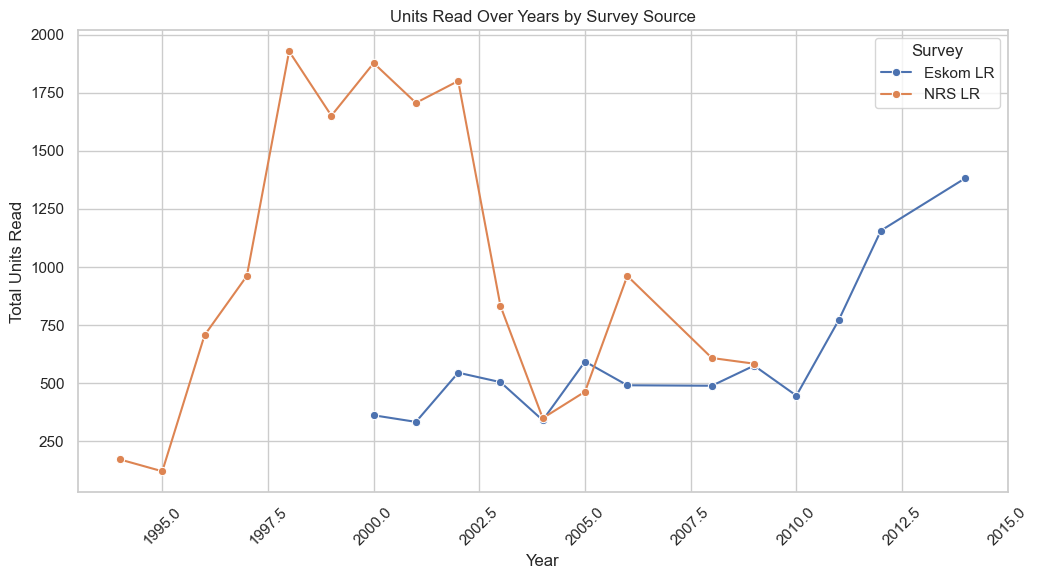

In [82]:
# Filter out rows where Survey is NaN
filtered = merged_dd[merged_dd['Survey'].isin(['NRS LR', 'Eskom LR'])]

# Group by Survey and Year
units_by_year = filtered.groupby(['Survey', 'Year'])['Unitsread'].sum().compute().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=units_by_year, x='Year', y='Unitsread', hue='Survey', marker='o')
plt.title("Units Read Over Years by Survey Source")
plt.ylabel("Total Units Read")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Does Unitsread grow as monthly_income increases?  
Monthly income was calculated as the sum of the variables returned by the earn per month, money from small business. Monthly income was adjusted for inflation by basing it against values
from Statistics South Africa for December 2016. Splitting up the income by brackets can give a clearer picture of the relationship between the Units. As expected we see higher income means higher units. 

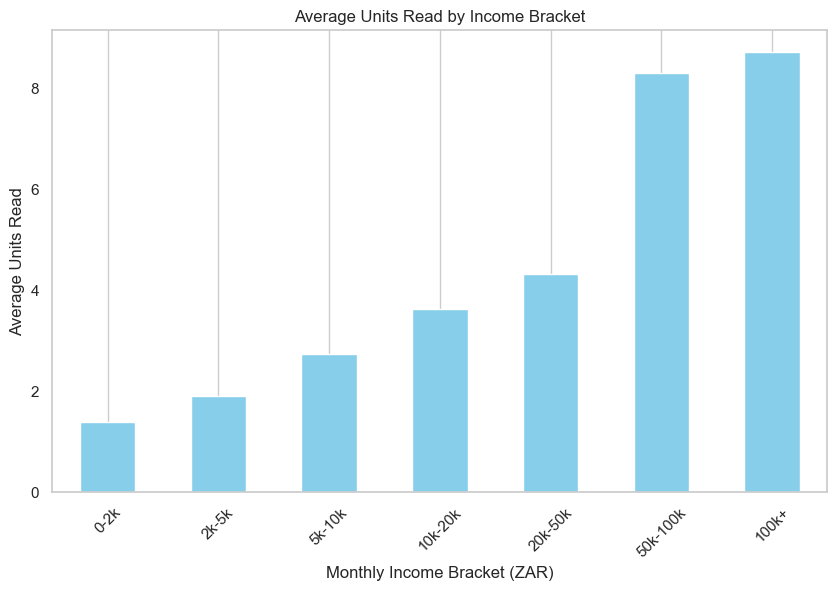

In [83]:
# Drop rows with missing values 
df_income_units = merged_dd[['Unitsread', 'monthly_income']].dropna().compute()

# Create income bins
bins = [0, 2000, 5000, 10000, 20000, 50000, 100000, df_income_units['monthly_income'].max()]
labels = ['0-2k','2k-5k','5k-10k','10k-20k','20k-50k','50k-100k','100k+']
df_income_units['income_bracket'] = pd.cut(df_income_units['monthly_income'], bins=bins, labels=labels, include_lowest=True)

# Average units read per income bracket
avg_units = df_income_units.groupby('income_bracket')['Unitsread'].mean()

# Plot
plt.figure(figsize=(10,6))
avg_units.plot(kind='bar', color='skyblue')
plt.title("Average Units Read by Income Bracket")
plt.xlabel("Monthly Income Bracket (ZAR)")
plt.ylabel("Average Units Read")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Is there a relationship between Unitsread and the population growth? 

Yes we can see they move together. Which signals that as population increases or decreases, the demand for power does too.

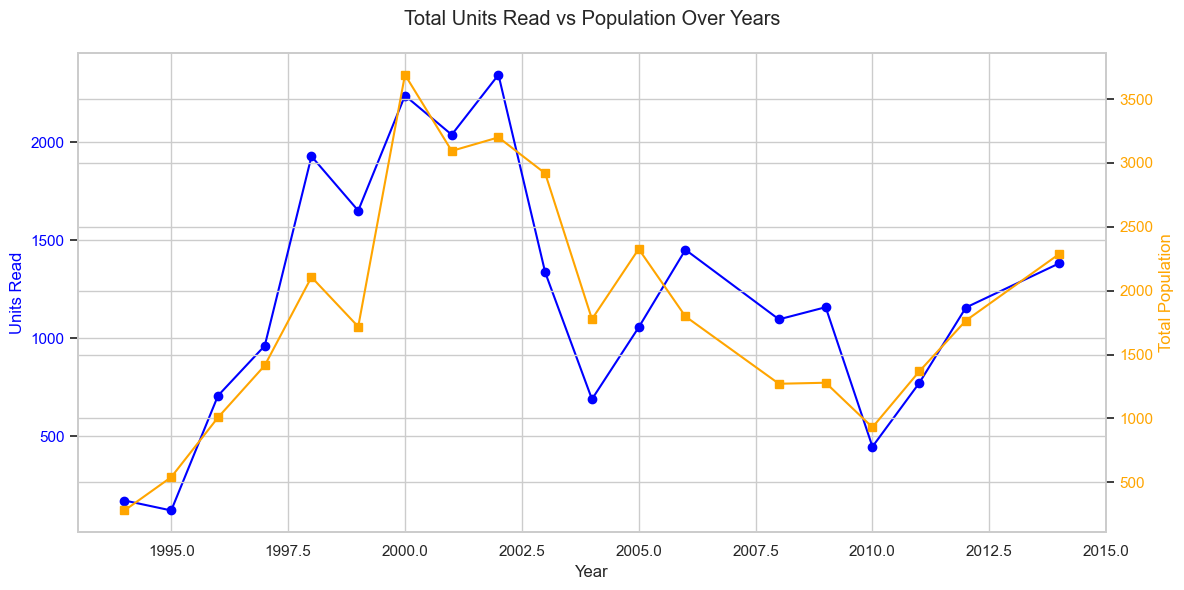

In [85]:
# Define total population 
merged_dd['total_population'] = merged_dd['total_adults'] + merged_dd['total_children']

# Calculate units per population 
pop_units = merged_dd.groupby('Year')[['Unitsread','total_population']].sum().compute()

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(pop_units.index, pop_units['Unitsread'], color='blue', marker='o', label='Units Read')
ax1.set_xlabel('Year')
ax1.set_ylabel('Units Read', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # create a second y-axis
ax2.plot(pop_units.index, pop_units['total_population'], color='orange', marker='s', label='Total Population')
ax2.set_ylabel('Total Population', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Total Units Read vs Population Over Years')
fig.tight_layout()
plt.grid(True)
plt.show()

### Is there a difference in the income levels between the two surveys?

The data measured in the Domestic Electrical Load (DEL) Study datasets were collected from households and it seems the monthly income went down after Eskom took over sponsorship;. 

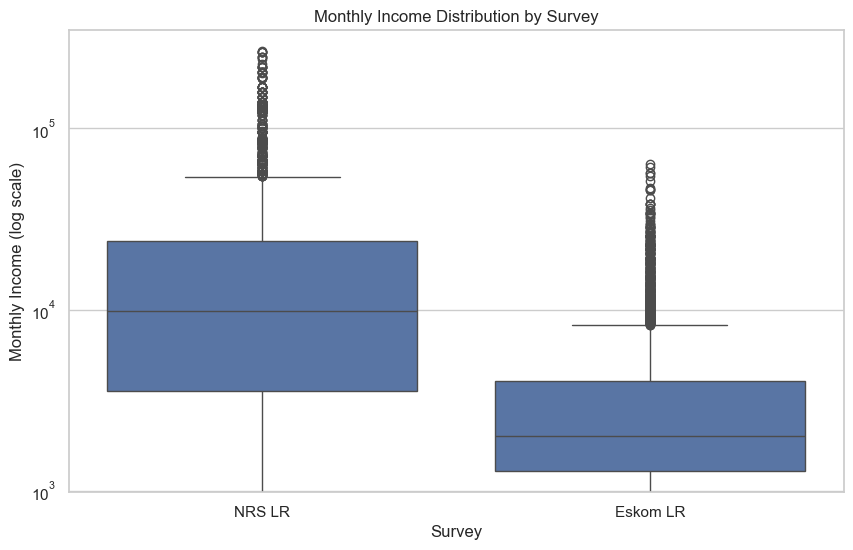

In [86]:
# Drop NaN values
income_data = merged_dd[['monthly_income', 'Survey']].dropna().compute()

# Filter out the two surveys and group the monthly income data
income_data = income_data[income_data['Survey'].isin(['NRS LR', 'Eskom LR'])]
income_data.groupby('Survey')['monthly_income'].agg(['mean','median','count'])

# Boxplot 
plt.figure(figsize=(10,6))
sns.boxplot(x='Survey', y='monthly_income', data=income_data)
plt.yscale('log')  # log-scale to handle skew
plt.title('Monthly Income Distribution by Survey')
plt.ylabel('Monthly Income (log scale)')
plt.show()

## Which areas had the longest electrification?

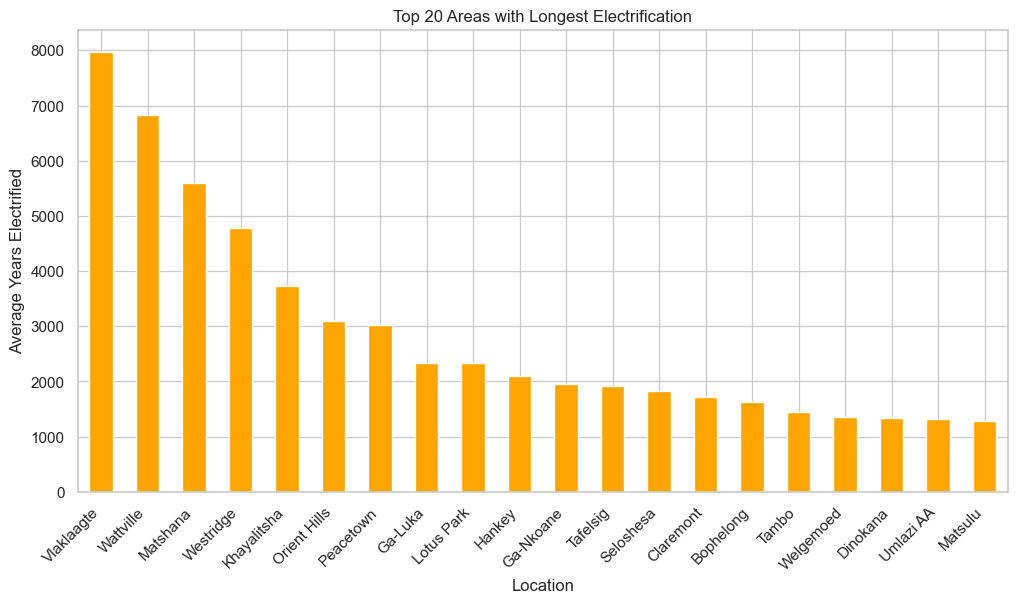

In [100]:
# Compute sum 
years_elec_total = merged_dd.groupby('LocName')['years_electrified'].sum().compute().sort_values(ascending=False) 

# Plot top 20
plt.figure(figsize=(12,6))
years_elec_total.head(20).plot(kind='bar', color='orange')
plt.xlabel('Location')
plt.ylabel('Average Years Electrified')
plt.title('Top 20 Areas with Longest Electrification')
plt.xticks(rotation=45, ha='right')
plt.show()

### What is the trend for electrifiction length?

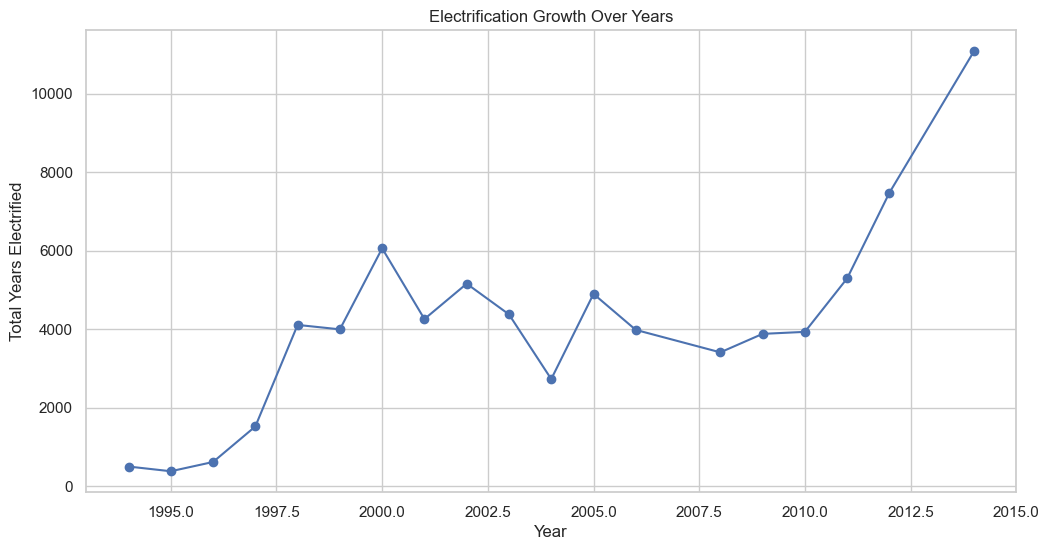

In [95]:
elec_per_year = merged_dd.groupby('Year')['years_electrified'].sum().compute()
elec_per_year.plot(figsize=(12,6), marker='o')
plt.xlabel('Year')
plt.ylabel('Total Years Electrified')
plt.title('Electrification Growth Over Years')
plt.show()